In [1]:

import pandas as pd
import numpy as np
import glob, time, os, cv2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import shutil
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model, optimizers, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Input, ZeroPadding2D, Add, AveragePooling2D, BatchNormalization, Conv2D, Dense, Activation, Flatten, Dropout, SpatialDropout2D, MaxPooling2D, GlobalMaxPooling2D, Input
from tensorflow.keras.models import Sequential, Model, model_from_json, model_from_yaml
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K

#from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

import matplotlib.pyplot as plt

df_path = '/home/Erdal.Genc/covid_work/deneme/Data_Entry_2017.csv'
img_path = '/mnt/dsets/ChestXrays/NIH/images'
img_path_new= '/home/Erdal.Genc/covid_work/deneme'

print(tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

img_height=224 #299
img_width=224 #299

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


Using TensorFlow backend.


2.2.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18121751406074012938
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6498720021005879303
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10698615680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14877642359055009223
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12533894796801774704
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
data = pd.read_csv(df_path)
data =data.rename(columns={"Image Index":"Image_Index"})

data_new = data[data.Image_Index != '00007523_000.png']
data_new.to_csv('/home/Erdal.Genc/covid_work/deneme/data_new.csv', index=False)
df_path_new = '/home/Erdal.Genc/covid_work/deneme/data_new.csv'
print(data_new[data['Image_Index']=='00007523_000.png']) ## to check if it is deleted

Empty DataFrame
Columns: [Image_Index, Finding Labels, Follow-up #, Patient ID, Patient Age, Patient Gender, View Position, OriginalImage[Width, Height], OriginalImagePixelSpacing[x, y], Unnamed: 11]
Index: []


/home/Erdal.Genc/anaconda3/envs/conda-env2/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [3]:
import csv

def create_label_directories(csv_filename, img_path):
    directories = set()
    img_path_new= '/home/Erdal.Genc/covid_work/deneme'
    with open(csv_filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(csvfile) # skip header row
        for row in reader:
            img_filename = str(row[0])
            labels = str(row[1])
            for label in labels.split('|'):
                #if label == "Hernia":
                    #continue
                src_file = os.path.join(img_path,img_filename)
                label = "_".join(label.split())
                dst_train_dir = os.path.join(img_path_new,"train",label)
                dst_train_file = os.path.join(dst_train_dir,img_filename)
                dst_valid_dir = os.path.join(img_path_new,"valid",label)
                dst_test_dir = os.path.join(img_path_new,"test",label)
                try:
                    if not os.path.exists(dst_train_dir):
                        os.makedirs(dst_train_dir)
                        directories.add(label)
                    if not os.path.exists(dst_valid_dir):
                        os.makedirs(dst_valid_dir)
                    if not os.path.exists(dst_test_dir):
                        os.makedirs(dst_test_dir)
                    src_file_abs = os.path.join(os.getcwd(),src_file)
                    dst_train_file_abs = os.path.join(os.getcwd(),dst_train_file)
                    #print("copy: " + src_file_abs + " to: " + dst_train_file_abs)
                    os.symlink(src_file_abs, dst_train_file_abs)
                except FileNotFoundError:
                    print("FileNotFoundError: " + src_file)
                else:
                    None
    return list(directories)

print(img_path)
directories = create_label_directories(df_path_new, img_path)
print(directories)

/mnt/dsets/ChestXrays/NIH/images
['Cardiomegaly', 'Pneumothorax', 'Atelectasis', 'Emphysema', 'Hernia', 'No_Finding', 'Consolidation', 'Nodule', 'Edema', 'Infiltration', 'Mass', 'Fibrosis', 'Pleural_Thickening', 'Effusion', 'Pneumonia']


In [4]:
def get_per_label_count(directories):
    per_label_count = []
    img_path_new= '/home/Erdal.Genc/covid_work/deneme'
    for ii in range(len(directories)):
        path, dirs, files = os.walk(os.path.join(img_path_new,"train",directories[ii])).__next__()
        file_count = len(files)
        per_label_count.append(file_count)
    return per_label_count
        
print(directories)
per_label_count = get_per_label_count(directories) 
print(per_label_count)

['Cardiomegaly', 'Pneumothorax', 'Atelectasis', 'Emphysema', 'Hernia', 'No_Finding', 'Consolidation', 'Nodule', 'Edema', 'Infiltration', 'Mass', 'Fibrosis', 'Pleural_Thickening', 'Effusion', 'Pneumonia']
[2776, 5302, 11559, 2516, 227, 60360, 4667, 6331, 2303, 19894, 5782, 1686, 3385, 13317, 1431]


In [5]:
def split_train_valid_test(directories, per_label_count, valid_pct, test_pct):
    img_path_new= '/home/Erdal.Genc/covid_work/deneme'
    for ii in range(len(directories)):
        all_img_paths = glob.glob(os.path.join(img_path_new,"train",directories[ii],"*.*"))
        np.random.shuffle(all_img_paths)
        label_count = per_label_count[ii]
        valid_count = int(label_count*valid_pct)
        valid_files = all_img_paths[:valid_count]
        all_img_paths[:valid_count] = []
        test_count = int(label_count*test_pct)
        test_files = all_img_paths[:test_count]
        all_img_paths[:test_count] = []
        #print(len(valid_files))
        #print(len(test_files))
        train_files = all_img_paths
        all_img_paths = []
        #print(len(train_files))
        for valid_file in valid_files:
            valid_file_abs = os.path.join(os.getcwd(),valid_file)
            #print("move: '" + valid_file_abs + "' to: '" + os.path.join(img_path,"valid",directories[ii]))
            shutil.move(valid_file_abs, os.path.join(img_path_new,"valid",directories[ii]))
        for test_file in test_files:
            test_file_abs = os.path.join(os.getcwd(),test_file)
            #print("move: '" + test_file_abs + "' to: '" + os.path.join(img_path,"test",directories[ii]))
            shutil.move(test_file_abs, os.path.join(img_path_new,"test",directories[ii]))
        
print(directories)
print(per_label_count)
valid_pct = 0.1
test_pct = 0.1       
split_train_valid_test(directories, per_label_count, valid_pct, test_pct)

['Cardiomegaly', 'Pneumothorax', 'Atelectasis', 'Emphysema', 'Hernia', 'No_Finding', 'Consolidation', 'Nodule', 'Edema', 'Infiltration', 'Mass', 'Fibrosis', 'Pleural_Thickening', 'Effusion', 'Pneumonia']
[2776, 5302, 11559, 2516, 227, 60360, 4667, 6331, 2303, 19894, 5782, 1686, 3385, 13317, 1431]


In [32]:

train_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

batch_size = 16

train_generator = train_datagen.flow_from_directory(
    '/home/Erdal.Genc/covid_work/deneme/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
    #color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
    '/home/Erdal.Genc/covid_work/deneme/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size, #val_batch_size,
    class_mode='categorical')
    
test_generator = test_datagen.flow_from_directory(
    '/home/Erdal.Genc/covid_work/deneme/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 113242 images belonging to 15 classes.
Found 14147 images belonging to 15 classes.
Found 14147 images belonging to 15 classes.


In [33]:
def H(  inputs, num_filters , dropout_rate ):
    x = tf.keras.layers.BatchNormalization( epsilon=eps )( inputs )
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D((1, 1))(x)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), use_bias=False , kernel_initializer='he_normal' )(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate )(x)
    return x

In [34]:
def transition(inputs, num_filters , compression_factor , dropout_rate ):
    # compression_factor is the 'θ'
    x = tf.keras.layers.BatchNormalization( epsilon=eps )(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    num_feature_maps = inputs.shape[1] # The value of 'm'

    x = tf.keras.layers.Conv2D( np.floor( compression_factor * num_feature_maps ).astype( np.int ) ,
                               kernel_size=(1, 1), use_bias=False, padding='same' , kernel_initializer='he_normal' , kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ) )(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    return x

In [35]:
def dense_block( inputs, num_layers, num_filters, growth_rate , dropout_rate ):
    for i in range(num_layers): # num_layers is the value of 'l'
        conv_outputs = H(inputs, num_filters , dropout_rate )
        inputs = tf.keras.layers.Concatenate()([conv_outputs, inputs])
        num_filters += growth_rate # To increase the number of filters for each layer.
    return inputs, num_filters

In [36]:
input_shape = ( 64 , 64 , 3 ) 
num_blocks = 3
num_layers_per_block = 4
growth_rate = 16
dropout_rate = 0.4
compress_factor = 0.5
eps = 1.1e-5
num_filters = 16


inputs = tf.keras.layers.Input( shape=input_shape )
x = tf.keras.layers.Conv2D( num_filters , kernel_size=( 3 , 3 ) , use_bias=False, kernel_initializer='he_normal' , kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ) )( inputs )

for i in range( num_blocks ):
    x, num_filters = dense_block( x, num_layers_per_block , num_filters, growth_rate , dropout_rate )
    x = transition(x, num_filters , compress_factor , dropout_rate )

x = tf.keras.layers.GlobalAveragePooling2D()( x ) 
x = tf.keras.layers.Dense( 15 )( x ) # Num Classes for NIH
outputs = tf.keras.layers.Activation( 'softmax' )( x )

In [37]:

#weights_path = 'denseNet_trial/denseNet_trial_weights.h5'
#model= ResNet50(input_shape=(img_height, img_width,3), classes= 15)
model = tf.keras.models.Model( inputs , outputs )
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 62, 62, 16)   432         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 62, 62, 16)   64          conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 62, 62, 16)   0           batch_normalization_54[0][0]     
____________________________________________________________________________________________

In [38]:
#nb_train_samples = 113242  #8094 #3036 #18046 #111589 #113243 #139987 
nb_validation_samples= 14147 
epochs = 200
history = model.fit_generator(
    train_generator,
    steps_per_epoch=batch_size, #nb_train_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=batch_size, #nb_validation_samples/batch_size, #val_batch_size,
    verbose=1)

Epoch 1/200
16/16 [==============================] - 11s 701ms/step - loss: 2.4533 - accuracy: 0.3555 - val_loss: 49.1167 - val_accuracy: 0.0742
Epoch 2/200
16/16 [==============================] - 10s 656ms/step - loss: 2.2391 - accuracy: 0.3984 - val_loss: 39.5115 - val_accuracy: 0.1055
Epoch 3/200
16/16 [==============================] - 11s 659ms/step - loss: 2.1663 - accuracy: 0.3594 - val_loss: 13.9309 - val_accuracy: 0.0820
Epoch 4/200
16/16 [==============================] - 11s 664ms/step - loss: 2.0897 - accuracy: 0.4102 - val_loss: 2.4998 - val_accuracy: 0.1406
Epoch 5/200
16/16 [==============================] - 10s 627ms/step - loss: 2.0939 - accuracy: 0.4297 - val_loss: 3.3509 - val_accuracy: 0.1406
Epoch 6/200
16/16 [==============================] - 10s 624ms/step - loss: 2.2149 - accuracy: 0.3398 - val_loss: 2.3987 - val_accuracy: 0.3438
Epoch 7/200
16/16 [==============================] - 12s 732ms/step - loss: 2.0652 - accuracy: 0.4219 - val_loss: 2.2521 - val_accura

16/16 [==============================] - 11s 658ms/step - loss: 1.9556 - accuracy: 0.4102 - val_loss: 9.0891 - val_accuracy: 0.0352
Epoch 114/200
16/16 [==============================] - 10s 628ms/step - loss: 2.0642 - accuracy: 0.4102 - val_loss: 9.3153 - val_accuracy: 0.0312
Epoch 115/200
16/16 [==============================] - 11s 709ms/step - loss: 2.0332 - accuracy: 0.4219 - val_loss: 2.0581 - val_accuracy: 0.4453
Epoch 116/200
16/16 [==============================] - 11s 675ms/step - loss: 2.0969 - accuracy: 0.3633 - val_loss: 2.0820 - val_accuracy: 0.4180
Epoch 117/200
16/16 [==============================] - 11s 715ms/step - loss: 2.0395 - accuracy: 0.4023 - val_loss: 2.9126 - val_accuracy: 0.1133
Epoch 118/200
16/16 [==============================] - 10s 650ms/step - loss: 2.0315 - accuracy: 0.4258 - val_loss: 2.4849 - val_accuracy: 0.2070
Epoch 119/200
16/16 [==============================] - 10s 641ms/step - loss: 2.1889 - accuracy: 0.3477 - val_loss: 2.3554 - val_accuracy:

In [39]:
steps=10
scores = model.evaluate_generator(test_generator, steps=steps, max_queue_size=10, workers=1, use_multiprocessing=False)
print("score = Loss: %f, Acc@1: %.2f" % (scores[0],scores[1]))

score = Loss: 2.428449, Acc@1: 0.19


In [20]:
import math
nb_test_samples = 14147
steps = math.ceil(nb_test_samples/batch_size)

def get_data_with_predictions(model,generator,steps,classes):
    X_test = np.zeros((0,img_height,img_width,3))
    y_test = np.zeros((0,classes))
    preds = np.zeros((0,classes))
    step_count = 0
    for batch_x, batch_y in generator:
        if step_count < steps:
            batch_preds = model.predict(batch_x)
            preds = np.vstack((preds,batch_preds))
            X_test = np.vstack((X_test,batch_x))
            y_test = np.vstack((y_test,batch_y))
            step_count = step_count + 1
        else:
            break
    return X_test, y_test, preds

num_classes=15
X_test, y_test, preds = get_data_with_predictions(model,test_generator,steps,num_classes)
print(X_test.shape)
print(y_test.shape)
print(preds.shape)


(14147, 224, 224, 3)
(14147, 15)
(14147, 15)


In [21]:
def get_tested_predictions(y_trues, preds):
    correct_preds = []
    incorrect_preds = []
    correct_count = 0
    incorrect_count = 0
    for ii in range(len(y_trues)):
        label_idx = np.argmax(y_trues[ii])
        prediction_idx = np.argmax(preds[ii])
        prediction = preds[ii][prediction_idx]
        if prediction_idx == label_idx:
            correct_preds.append(prediction)
            incorrect_preds.append(np.nan)
            correct_count = correct_count + 1
        if prediction_idx != label_idx:
            incorrect_preds.append(prediction)
            correct_preds.append(np.nan)
            incorrect_count = incorrect_count + 1
    return correct_preds, correct_count, incorrect_preds, incorrect_count

correct_preds, correct_count, incorrect_preds, incorrect_count = get_tested_predictions(y_test,preds)
print("Correct predictions: %d/%d" % (correct_count,len(preds)))
print("Incorrect predictions: %d/%d" % (incorrect_count,len(preds)))

Correct predictions: 3140/14147
Incorrect predictions: 11007/14147


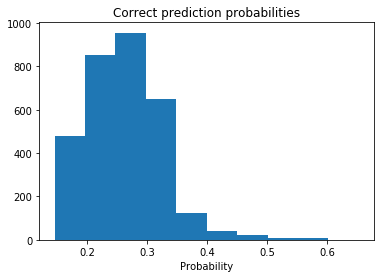

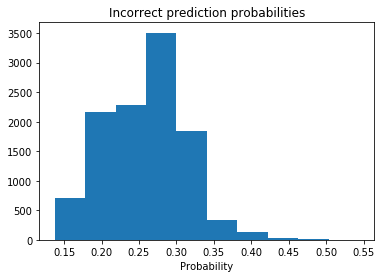

In [22]:
def plot_predictions_histogram(preds,title):
    nan_indices = np.where(~np.isnan(preds))
    preds_sin_nan = []
    nan_indices_sq = np.squeeze(nan_indices)
    for ii in range(len(nan_indices_sq)):
        preds_sin_nan.append(preds[nan_indices_sq[ii]])
    plt.figure()
    plt.hist(preds_sin_nan)
    plt.title(title)
    plt.xlabel('Probability');
    plt.show()
    
plot_predictions_histogram(correct_preds,"Correct prediction probabilities")
plot_predictions_histogram(incorrect_preds,"Incorrect prediction probabilities")

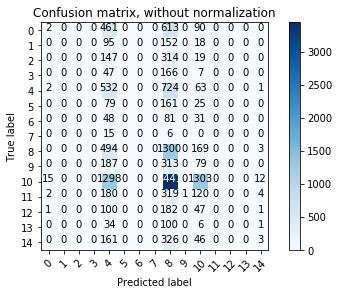

In [23]:

import itertools
from sklearn.metrics import confusion_matrix

y_trues = [np.argmax(ii) for ii in y_test]
y_preds = [np.argmax(ii) for ii in preds]

# credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_trues, y_preds)
class_names=list(set(np.concatenate((y_trues,y_preds),axis=0)))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

In [28]:
def classify(label):
    if label == 14:
        return 'No Finding'
    elif label == 0:
        return 'Atelectasis'
    elif label == 1:
        return 'Cardiomegaly'
    elif label == 2:
        return 'Consolidation'
    elif label == 3:
        return 'Edema'
    elif label == 4:
        return 'Effusion'
    elif label == 5:
        return 'Emphysema'
    elif label == 6:
        return 'Fibrosis'
    elif label == 7:
        return 'Hernia'
    elif label == 8:
        return 'Infiltration'
    elif label == 9:
        return 'Mass'
    elif label == 10:
        return 'Nodule'
    elif label == 11:
        return 'Pleural_Thickening'
    elif label == 12:
        return 'Pneumonia'
    elif label == 13:
        return 'Pneumothorax'
    else:
        return 'Unknown'
    
def pretty_print_predictions(idx, y_valid, preds): 
    true_label = np.argmax(y_valid[idx])
    print("True label: " + str(true_label) + " - " + classify(true_label))
    predicted_label = np.argmax(preds[idx])
    print("Pred label: " + str(predicted_label) + " - " + classify(predicted_label))
    prediction = preds[idx][predicted_label]
    print("Prediction: " + str(prediction))
    print("Confident?: " + str(measure_confidence(prediction,preds)))
    top_5 = preds[idx].argsort()[-5:][::-1]
    print("Top 5 labels: " + str(top_5))
    count = 1
    for label in top_5:
        print(str(count) + ". " + classify(label))
        count = count + 1

def get_outlier_threshold(percentile,factor):
    return (percentile+factor)

def get_max_predictions(preds):
    new_preds = []
    tmp = list(preds)
    for ii in range(len(preds)):
        prediction_idx = np.argmax(tmp[ii])
        prediction = preds[ii][prediction_idx]
        new_preds.append(prediction)
    return new_preds
    
def measure_confidence(prediction,preds):
    factor = 3.0
    q75, q25 = np.nanpercentile(get_max_predictions(preds), [75,25])
    print("(Q3: " + str(q75) + ", Q1: " + str(q25) + ")")
    confident_threshold = get_outlier_threshold(q75,(factor/100))
    if prediction >= confident_threshold:
        return True
    else:
        return False

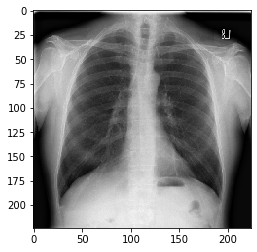

(1, 224, 224, 3)

True label: 8 - Infiltration
Pred label: 10 - Nodule
Prediction: 0.2577706277370453
(Q3: 0.2973997890949249, Q1: 0.21580643951892853)
Confident?: False
Top 5 labels: [10  8 14 11  4]
1. Nodule
2. Infiltration
3. No Finding
4. Pleural_Thickening
5. Effusion


In [29]:
def get_image(img,display=False):
    # if 'img' is a NumPy array, then it has already been loaded; just show it
    if type(img).__module__ == np.__name__:
        return img
    else:
        image = load_img(img, target_size=(img_width, img_height)) #, grayscale=True)
        #image = Image.open(img_path).convert("L")
        #image = image.resize((img_height,img_width), Image.ANTIALIAS)
        return np.asarray(image)

def get_image_batch(img,display=False):
    image_arr = get_image(img,display)
    if display == True:
        plt.figure()
        plt.imshow(image_arr)
        plt.show()
    return np.expand_dims(image_arr,axis=0)

from random import randint

def get_random_image(X_data):
    idx = randint(0,len(X_data)-1)
    return get_image_batch(X_data[idx],True), idx
    
image_batch, idx = get_random_image(X_test)
print(image_batch.shape)
print()
pretty_print_predictions(idx,y_test,preds)

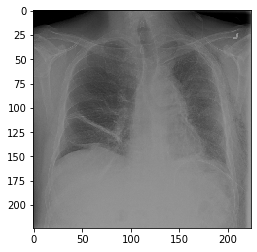

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


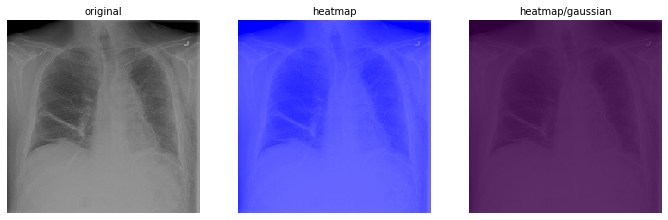

In [33]:
from vis.visualization import visualize_saliency, visualize_cam, visualize_activation, overlay
def visualize_top_convolution(model,image_batch):
    layer_idx=-1
    #print(model.layers[layer_idx].name)

    # credit: https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb
    #heatmap = visualize_cam(model, layer_idx=-1, filter_indices=None, seed_input=image_batch, grad_modifier='small_values')
    heatmap = visualize_saliency(model, layer_idx=-1, filter_indices=None, seed_input=image_batch, grad_modifier='small_values')
    #activations = visualize_activation(model, layer_idx=-1, filter_indices=[10])

    img = image_batch.squeeze()

    # credit: (gaussian filter for a better UI) http://bradsliz.com/2017-12-21-saliency-maps/
    import scipy.ndimage as ndimage
    smooth_heatmap = ndimage.gaussian_filter(heatmap[:,:,2], sigma=5)
    #smooth_activations = ndimage.gaussian_filter(activations[:,:,2], sigma=5)

    nn = 5
    fig = plt.figure(figsize=(20,20))
    a = fig.add_subplot(1, nn, 1)
    plt.imshow(img)
    a.set_title("original",fontsize=10)
    plt.axis('off')
    a = fig.add_subplot(1, nn, 2)
    plt.imshow(overlay(img, heatmap, alpha=0.7))
    a.set_title("heatmap",fontsize=10)
    plt.axis('off')
    a = fig.add_subplot(1, nn, 3)
    plt.imshow(img)
    plt.imshow(smooth_heatmap, alpha=0.7)
    a.set_title("heatmap/gaussian",fontsize=10)
    plt.axis('off')
    #a = fig.add_subplot(1, nn, 4)
    #plt.imshow(overlay(img, activations, alpha=0.7))
    #a.set_title("activations",fontsize=10)
    #plt.axis('off')
    # better to show with entire model (including "top")
    #a = fig.add_subplot(1, nn, 5)
    #plt.imshow(img)
    #plt.imshow(smooth_activations, alpha=0.7)
    #a.set_title("activations/guassian",fontsize=10)
    #plt.axis('off')
    plt.show()

image_batch, _ = get_random_image(X_test)
visualize_top_convolution(model,image_batch)